In [1]:
import gzip
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import plotly.express as px

sys.path.append('../modules')
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#Open file
#filepath = '/work/friemer/hgcalml/SimpleCocoa/analyseSimpleCocoa/analysisoutput'
filepath = '/work/friemer/hgcalml/CocoaTotalEnergyQmin01PhiEta/analysisoutput'
filepath = '/work/friemer/hgcalml/analysisoutputoldmatchingfixedID'
filepath = '/work/friemer/hgcalml/analysisoutputfixedID'
filepath = '/work/friemer/hgcalml/analysisoutputtidx2'
filepath = '/work/friemer/hgcalml/analysisoutputtidx2cocoaa'
filepath = '/work/friemer/hgcalml/analysisoutputtidx5cocoa'
filepath = '/work/friemer/hgcalml/analysisoutputfixedNormtidx'
filepath = '/work/friemer/hgcalml/analysisoutputfixedNormcontinue'
filepath = '/work/friemer/hgcalml/analysistidx6'
filepath = '/work/friemer/hgcalml/analysisTidx9'
filepath = '/work/friemer/hgcalml/analysisTidx9cocoamatch'

# Open the file and load the data
with gzip.open(filepath, 'rb') as input_file:
    analysis_data = pickle.load(input_file)
    
# Print the keys of the data
print('Analysis data keys:', analysis_data.keys())
print('shower keys ',analysis_data['showers_dataframe'].keys())
print('scalar keys',analysis_data['scalar_variables'].keys())
#print(analysis_data['alpha_ids'])
#print(analysis_data['matched'])
print('features list keys', analysis_data['features'][0].keys())
print('truth list keys', analysis_data['truth'][0].keys())
print('prediction list keys', analysis_data['prediction'][0].keys())

df = analysis_data['showers_dataframe']
feature_list =  analysis_data['features']
t_list = analysis_data['truth']
pred_list = analysis_data['prediction']

df['pred_id_value'] = df['pred_id'].apply(lambda x: np.argmax(x))

has_truth = np.isnan(df['truthHitAssignedEnergies']) == False
has_pred = np.isnan(df['pred_energy']) == False
matched = np.logical_and(has_truth, has_pred)

2024-07-23 13:50:08.153579: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 13:50:08.906419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


Analysis data keys: dict_keys(['showers_dataframe', 'scalar_variables', 'alpha_ids', 'matched', 'features', 'truth', 'prediction'])
shower keys  Index(['truthHitAssignedPhi', 'pred_ccoords', 'pred_beta', 'pred_sid',
       't_rec_energy', 'truthHitAssignementIdx', 'hasTrack', 'pred_time',
       'truthHitSpectatorFlag', 'pred_energy', 'truthHitAssignedY', 't_idx',
       'truthHitAssignedPIDs', 'truthHitAssignedEnergies', 'truthHitAssignedT',
       'pred_id', 'pred_dist', 'truthHitAssignedX', 'pred_pos',
       'truthHitFullyContainedFlag', 'truthHitAssignedEta',
       'truthHitAssignedZ', 'event_id'],
      dtype='object')
scalar keys dict_keys(['beta_threshold', 'distance_threshold', 'iou_threshold', 'matching_mode', 'de_e_cut', 'angle_cut'])
features list keys dict_keys(['recHitEnergy', 'recHitEta', 'recHitID', 'recHitTheta', 'recHitR', 'recHitX', 'recHitY', 'recHitZ', 'recHitTime', 'recHitHitR', 'recHitXY'])
truth list keys dict_keys(['truthHitAssignementIdx', 'truthHitAssignedEn

## Neutral Efficiency, Fakerate, p

/tmp/ipykernel_536938/840209094.py:48: RuntimeWarning: invalid value encountered in double_scalars
  fake_err = np.sqrt(fake * (1 - fake) / np.sum(faked[mask_PID_pred]))
/tmp/ipykernel_536938/840209094.py:47: RuntimeWarning: invalid value encountered in long_scalars
  fake = np.sum(faked[mask_PID_pred]) / np.sum(mask_binpred[mask_PID_pred])


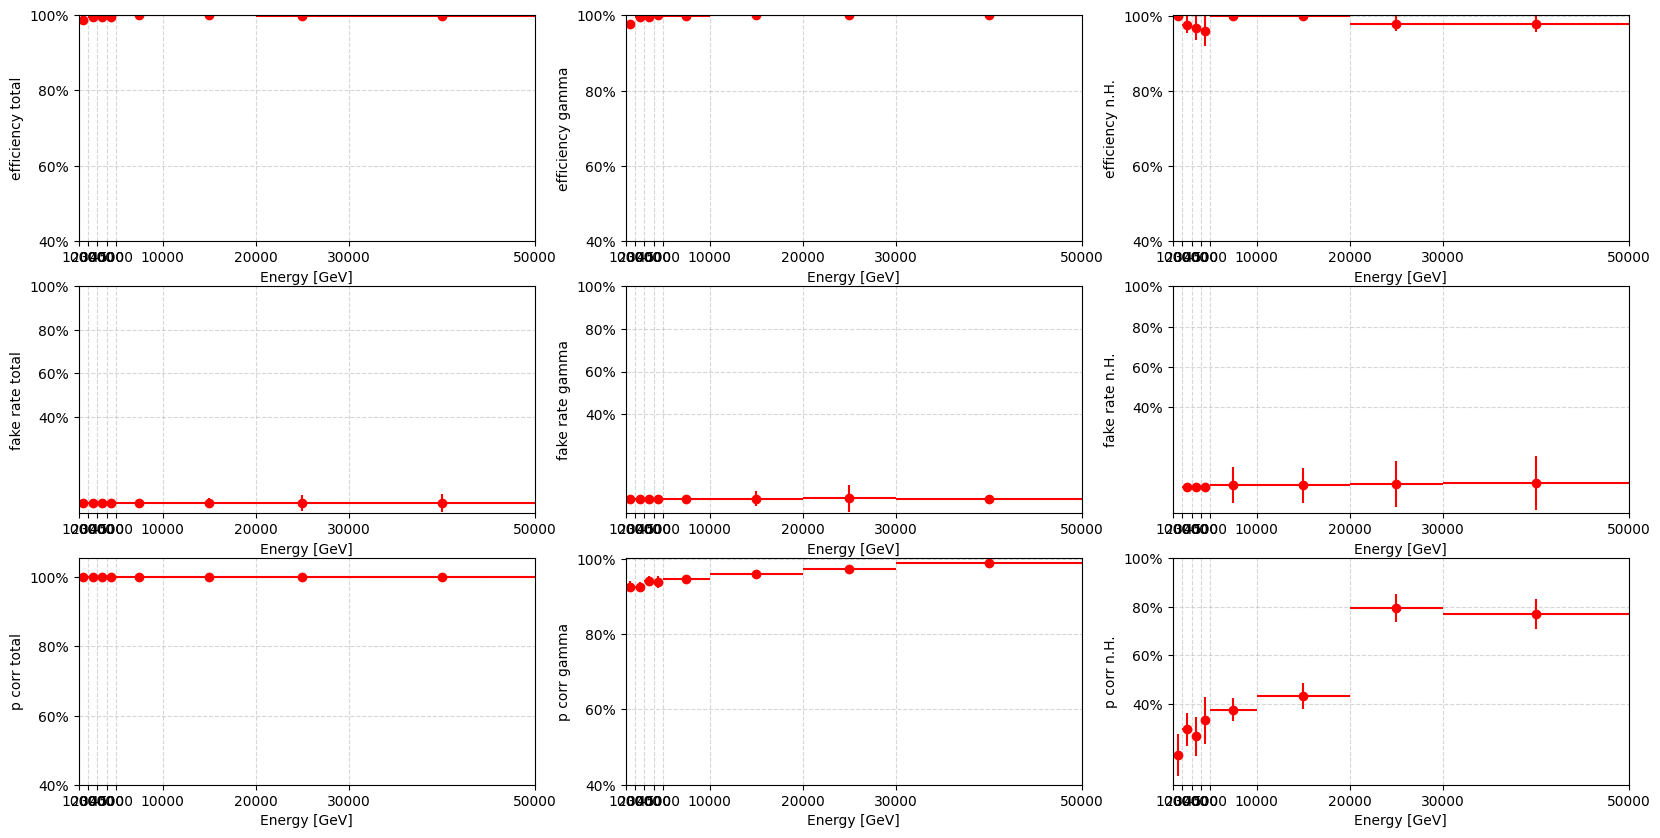

In [3]:
def help_calc_efficiencies(df, bins, mask=None):
    efficiencies = []
    efficiencies_err = []
    fake_rate = []
    fake_rate_err = []
    corr_class_prob = []
    corr_class_prob_err = []    
    
    mask_predicted = np.isnan(df['pred_energy']) == False
    mask_truth = np.isnan(df['truthHitAssignedEnergies']) == False
    
    if mask == None:
        mask_PID_truth = np.ones(len(df), dtype=bool)
        mask_PID_pred = mask_PID_truth
    else:
        if(mask == 0):
            mask_PID_truth = df['truthHitAssignedPIDs'].isin([22])
        elif(mask == 1):
            mask_PID_truth = df['truthHitAssignedPIDs'].isin([130,310,311,2112,-2112,3122,-3122,3322,-3322])
        else:
            raise ValueError("mask must be 0 or 1")
        mask_PID_pred = df['pred_id_value'].isin([mask])
        
    mask_PID_matched = np.logical_and(mask_PID_truth, mask_PID_pred)
        
    
    for i in range(len(bins) - 1):
        mask_bintruth = np.logical_and(
            df['truthHitAssignedEnergies'] >= bins[i],
            df['truthHitAssignedEnergies'] < bins[i + 1])
        mask_binpred = np.logical_and(
            df['pred_energy'] >= bins[i],
            df['pred_energy'] < bins[i + 1])

        matched = np.logical_and(
            mask_predicted,
            mask_bintruth)
        faked = np.logical_and(
            mask_binpred,
            np.logical_not(mask_truth))
        
        eff = np.sum(matched[mask_PID_truth]) / np.sum(mask_bintruth[mask_PID_truth])
        eff_err = np.sqrt(eff * (1 - eff) / np.sum(matched[mask_PID_truth])) 
        efficiencies.append(eff)
        efficiencies_err.append(eff_err)
        
        fake = np.sum(faked[mask_PID_pred]) / np.sum(mask_binpred[mask_PID_pred])
        fake_err = np.sqrt(fake * (1 - fake) / np.sum(faked[mask_PID_pred]))
        fake_rate.append(fake)
        fake_rate_err.append(fake_err)
        
        cc_prob = np.sum(matched[mask_PID_matched]) / np.sum(matched[mask_PID_truth])
        cc_prob_err = np.sqrt(cc_prob * (1 - cc_prob) / np.sum(matched[mask_PID_truth]))
        corr_class_prob.append(cc_prob)
        corr_class_prob_err.append(cc_prob_err)
    
    return np.array(efficiencies), np.array(efficiencies_err), np.array(fake_rate), np.array(fake_rate_err), np.array(corr_class_prob), np.array(corr_class_prob_err)

def efficiency_plots(df, bins):
    # Calculate the bin positions and widths
    binwidth = bins[1:] - bins[:-1]
    x_pos = bins[:-1] + binwidth / 2
    x_err = binwidth / 2
    
    # Calculate the efficiencies and fake rates for the total
    yeff, yerr_eff, yfake, yerr_fake, ycorr, yerr_corr = help_calc_efficiencies(df, bins)
    yeff, yerr_eff, yfake, yerr_fake, ycorr, yerr_corr = \
        yeff*100, yerr_eff*100, yfake*100, yerr_fake*100, ycorr*100, yerr_corr*100
    
    # Calculate the efficiencies and fake rates for the photons
    yeff_photon, yerr_eff_photon, yfake_photon, yerr_fake_photon, ycorr_photon, yerr_corr_photon = help_calc_efficiencies(df, bins, 0)
    yeff_photon, yerr_eff_photon, yfake_photon, yerr_fake_photon, ycorr_photon, yerr_corr_photon = \
        yeff_photon*100, yerr_eff_photon*100, yfake_photon*100, yerr_fake_photon*100, ycorr_photon*100, yerr_corr_photon*100
    
    # Calculate the efficiencies and fake rates for the neutral hadrons
    #130: "K0L", 310: "K0S", 311: "K0", 2112: "neutron",-2112: "antineutron",3122: "Lambda",-3122: "antilambda"3322: "Xi0",-3322: "antixi0"
    yeff_nh, yerr_eff_nh, yfake_nh, yerr_fake_nh, ycorr_nh, yerr_corr_nh = help_calc_efficiencies(df, bins, 1)
    yeff_nh, yerr_eff_nh, yfake_nh, yerr_fake_nh, ycorr_nh, yerr_corr_nh = \
        yeff_nh*100, yerr_eff_nh*100, yfake_nh*100, yerr_fake_nh*100, ycorr_nh*100, yerr_corr_nh*100
    
    # Create the plots
    fig, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
    ax1.errorbar(x_pos, yeff, xerr=x_err, yerr=yerr_eff, fmt='o', color='red', label='Efficiency')
    ax1.set_ylabel('efficiency total', fontsize=10)
    ax2.errorbar(x_pos, yeff_photon, xerr=x_err, yerr=yerr_eff_photon, fmt='o', color='red', label='Efficiency')
    ax2.set_ylabel('efficiency gamma', fontsize=10)
    ax3.errorbar(x_pos, yeff_nh, xerr=x_err, yerr=yerr_eff_nh, fmt='o', color='red', label='Efficiency')
    ax3.set_ylabel('efficiency n.H.', fontsize=10)
    
    ax4.errorbar(x_pos, yfake, xerr=x_err, yerr=yerr_fake, fmt='o', color='red', label='Fake rate')
    ax4.set_ylabel('fake rate total', fontsize=10)
    ax5.errorbar(x_pos, yfake_photon, xerr=x_err, yerr=yerr_fake_photon, fmt='o', color='red', label='Fake rate')
    ax5.set_ylabel('fake rate gamma', fontsize=10)
    ax6.errorbar(x_pos, yfake_nh, xerr=x_err, yerr=yerr_fake_nh, fmt='o', color='red', label='Fake rate')
    ax6.set_ylabel('fake rate n.H.', fontsize=10)
    
    ax7.errorbar(x_pos, ycorr, xerr=x_err, yerr=yerr_corr, fmt='o', color='red', label='probability of correct class')
    ax7.set_ylabel('p corr total', fontsize=10)
    ax8.errorbar(x_pos, ycorr_photon, xerr=x_err, yerr=yerr_corr_photon, fmt='o', color='red', label='probability of correct class')
    ax8.set_ylabel('p corr gamma', fontsize=10)
    ax9.errorbar(x_pos, ycorr_nh, xerr=x_err, yerr=yerr_corr_nh, fmt='o', color='red', label='probability of correct class')
    ax9.set_ylabel('p corr n.H.', fontsize=10)

    for ax in [ax1, ax2,ax3, ax4, ax5, ax6, ax7, ax8, ax9]:    
        ax.set_xticks(bins)
        ax.set_xticklabels(bins, fontsize=10)
        ax.set_xlim(bins[0], bins[-1])
        ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
        ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
        ax.set_xlabel('Energy [GeV]', fontsize=10)
    
        yticks1 = np.round(np.arange(40, 101, 20), 1)
        ax.set_yticks(yticks1)
        ax.set_yticklabels([f"{y}%" for y in yticks1], fontsize=10)
        #ax.set_ylim(20, 101)

    return fig
energy_bins = np.array([1,2,3,4,5,10,20,30,50])*1000
fig=efficiency_plots(df, bins=energy_bins)

## Jet nParticles, deltaE, deltaphi, deltaEta

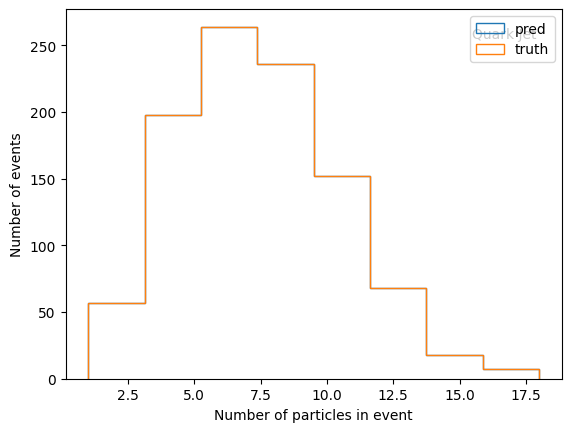

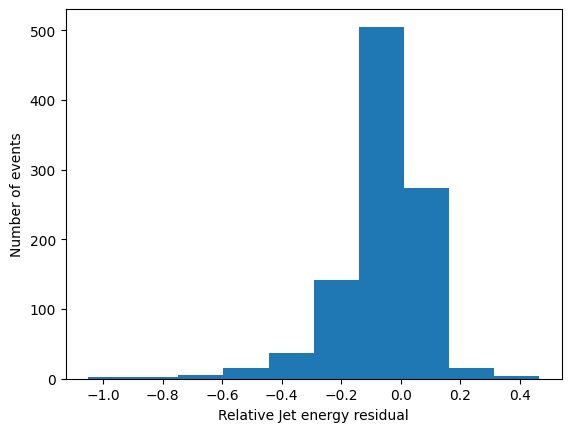

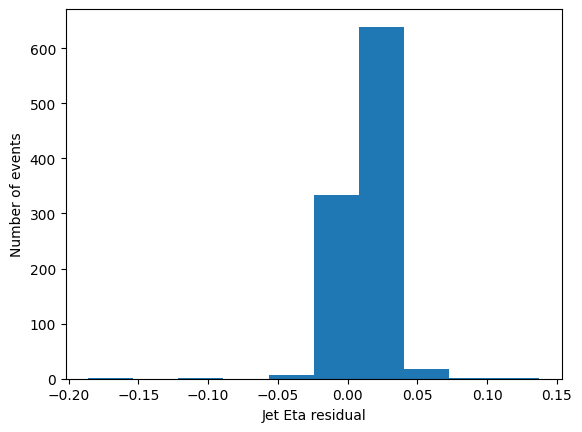

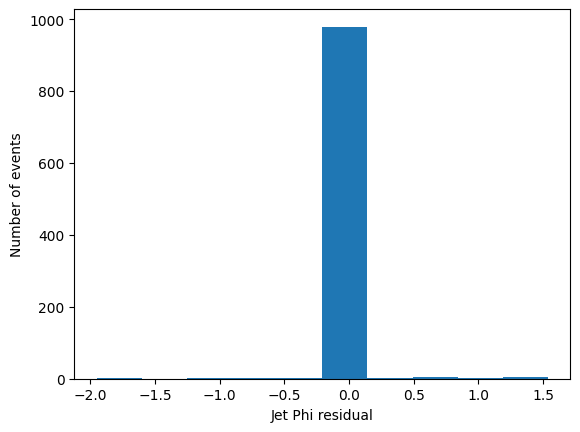

In [4]:
#Jet metrics
reseta = []
resphi = []
relresE = []
nParicles_pred = []
nParicles_truth = []

for i in range(len(t_list)):
    mask = np.logical_and(df['event_id'] == i, matched)
    jet_E_truth = np.sum(df[mask]['truthHitAssignedEnergies'])
    jet_E_pred = np.sum(df[mask]['pred_energy'])
    relresE.append((jet_E_truth-jet_E_pred)/jet_E_truth)
    
    nParicles_pred.append(len(df[mask]['pred_sid']))
    nParicles_truth.append(len(df[mask]['truthHitAssignementIdx']))
    
    t_eta = np.mean(df[mask]['truthHitAssignedZ'])
    pred_eta = df[mask]['pred_pos'].apply(lambda x: x[2]).mean()
    reseta.append(t_eta-pred_eta)
    
    t_phi = np.mean(np.arctan2(df[mask]['truthHitAssignedY'], df[mask]['truthHitAssignedX']))
    pred_phi = df[mask]['pred_pos'].apply(lambda x: np.arctan2(x[1], x[0])).mean()
    delta_phi = t_phi-pred_phi
    delta_phi = np.where(delta_phi > np.pi, delta_phi-2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi+2*np.pi, delta_phi)
    resphi.append(delta_phi)

bins = np.linspace(1, 18, 9)
plt.hist(nParicles_pred, bins=bins, label='pred', histtype='step')
plt.hist(nParicles_truth, bins=bins, label='truth', histtype='step')
plt.text(0.95, 0.95, 'Quark Jet', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
plt.ylabel('Number of events')
plt.xlabel('Number of particles in event')
plt.legend()
plt.show()

plt.hist(relresE)
plt.ylabel('Number of events')
plt.xlabel('Relative Jet energy residual')
plt.show()

plt.hist(reseta)
plt.ylabel('Number of events')
plt.xlabel('Jet Eta residual')
plt.show()

plt.hist(resphi)
plt.ylabel('Number of events')
plt.xlabel('Jet Phi residual')
plt.show()

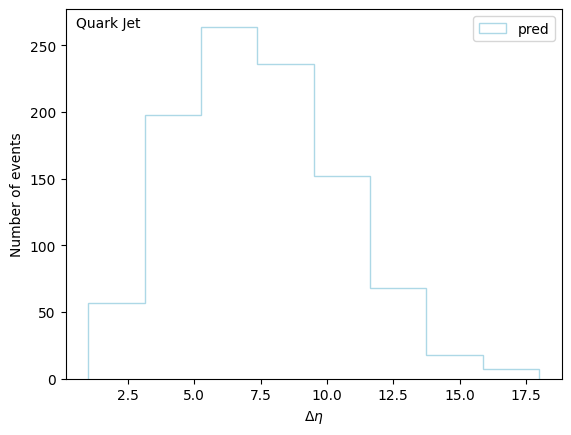

In [12]:
bins = np.linspace(1, 18, 9)
#set color to #67c4ce
plt.hist(nParicles_pred, bins=bins, label='pred', histtype='step', color='#67c4ce')
#plt.hist(nParicles_truth, bins=bins, label='truth', histtype='step')
plt.text(0.02, 0.98, 'Quark Jet', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
plt.ylabel('Number of events')
plt.xlabel("$\\Delta \\eta$")
plt.legend()
plt.show()

## Neutral Particles E, phi, eta

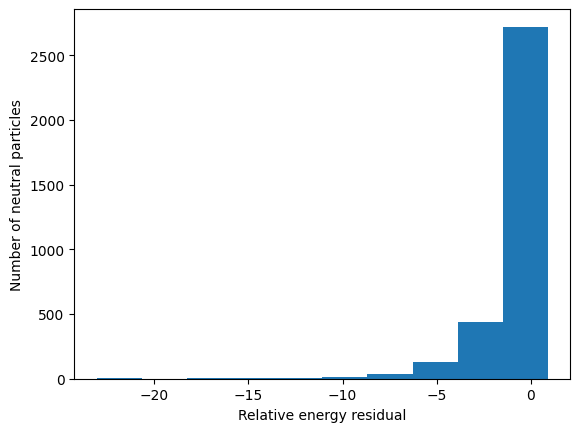

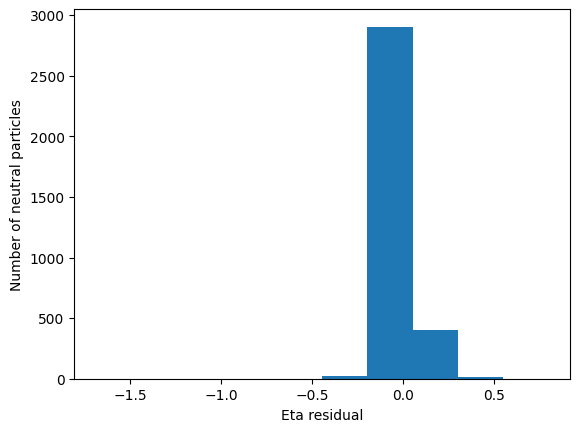

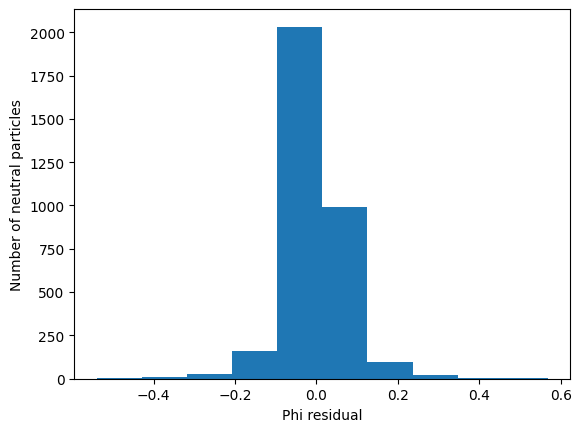

In [6]:
mask_neutral = df['truthHitAssignedPIDs'].isin([22,130, 310, 311, 2112, -2112, 3122, -3122, 3322, -3322])
mask_neutral_match = np.logical_and(mask_neutral, matched)

#neutral particles 
reseta = []
resphi = []
relresE = []

for i in range(len(t_list)):
    mask = np.logical_and(df['event_id'] == i, mask_neutral_match)
    truth_e = df[mask]['truthHitAssignedEnergies']
    pred_e = df[mask]['pred_energy']
    newrelresE = ((truth_e-pred_e)/truth_e).to_numpy()
    relresE = np.concatenate((relresE, newrelresE))
    
    t_eta = df[mask]['truthHitAssignedZ']
    pred_eta = df[mask]['pred_pos'].apply(lambda x: x[2])
    delta_eta = (t_eta-pred_eta).to_numpy()
    reseta = np.concatenate((reseta, delta_eta))
    
    t_phi = np.arctan2(df[mask]['truthHitAssignedY'], df[mask]['truthHitAssignedX'])
    pred_phi = df[mask]['pred_pos'].apply(lambda x: np.arctan2(x[1], x[0]))
    delta_phi = (t_phi-pred_phi).to_numpy()
    delta_phi = np.where(delta_phi > np.pi, delta_phi-2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi+2*np.pi, delta_phi)

    resphi = np.concatenate((resphi, delta_phi))

plt.hist(relresE)
plt.ylabel('Number of neutral particles')
plt.xlabel('Relative energy residual')
plt.show()

plt.hist(reseta)
plt.xlabel('Eta residual')
plt.ylabel('Number of neutral particles')
plt.show()


plt.hist(resphi)
plt.xlabel('Phi residual')
plt.ylabel('Number of neutral particles')
plt.show()



## Charged Energy Resolution

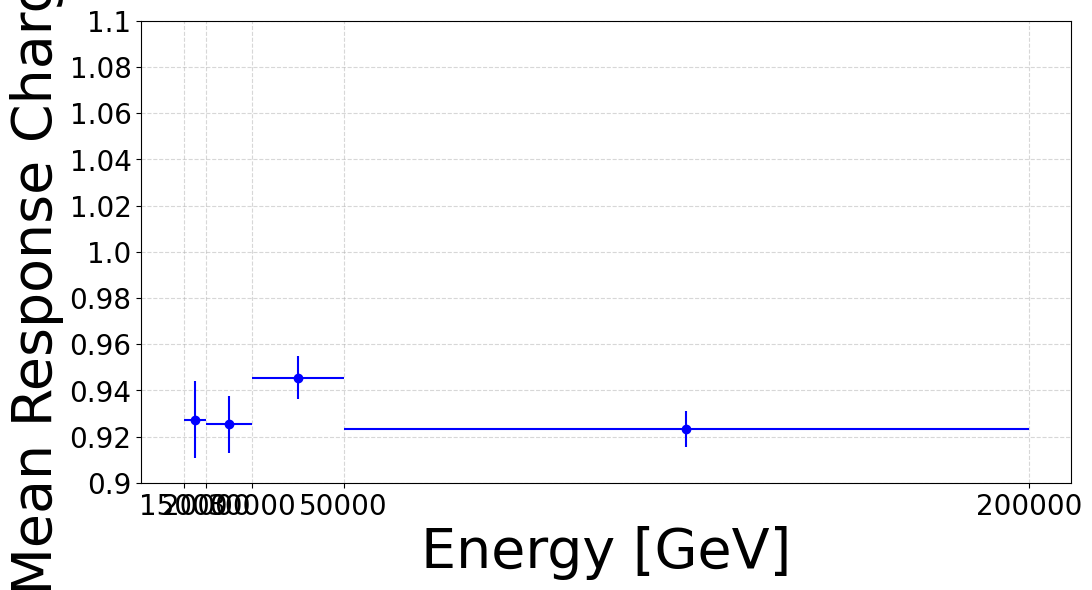

In [7]:
def energy_resolution(df, bins=None):
    has_truth = np.isnan(df['truthHitAssignedEnergies']) == False
    has_pred = np.isnan(df['pred_energy']) == False
    matched = np.logical_and(has_truth, has_pred)

    means = []
    std_error = []

    for i in range(len(bins) - 1):
        mask_truth_bin = np.logical_and(
            df['truthHitAssignedEnergies'] >= bins[i],
            df['truthHitAssignedEnergies'] < bins[i + 1])
        mask_bin = np.logical_and(mask_truth_bin, matched)
        ratios = df['pred_energy'][mask_bin] / df['truthHitAssignedEnergies'][mask_bin]
        means.append(np.mean(ratios))
        std_error.append(np.std(ratios) / np.sqrt(len(ratios)))

    # make boxplots of the ratios for each bin
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    binwidth = bins[1:] - bins[:-1]
    x = bins[:-1] + binwidth / 2
    xerr = binwidth / 2    
    y = means
    yerr = std_error
    
    # plot x, y with error bars
    ax1.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', color='blue', zorder=2, label='Mean Response')
    
    # set xticks
    xticks = np.round(bins, 0).astype(int)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks, fontsize=20)
    ymin = np.round(ax1.get_ylim()[0], 1)
    ymax = np.round(ax1.get_ylim()[1], 1)
    ydelta = max(1 - ymin, ymax - 1)
    ax1.set_ylim(1 - ydelta, 1 + ydelta)    
    # set yticks to be evenly spaced around 1
    yticks = np.round(np.arange(1 - ydelta, 1 + ydelta, 0.02), 2)
    yticks = np.round(np.linspace(1 - ydelta, 1 + ydelta, 11), 2)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticks, fontsize=20)
    
    ax1.grid(alpha=0.5, linestyle='--')
    ax1.set_ylabel('Mean Response Charged', fontsize=40)
    ax1.set_xlabel('Energy [GeV]', fontsize=40)
    
    return fig


energy_bins = np.array([15,20,30,50,200])*1000
charged_mask = df['truthHitAssignedPIDs'].isin([11,-11,13,-13,211,-211,321,-321,2212,-2212,3112,-3112,3222,-3222,3312,-3312])
fig=energy_resolution(df[charged_mask], bins=energy_bins)

In [8]:
def plot_condensation(event_id, pred_list, t_list, feature_list, location='/work/friemer/hgcalml/condensationplots/condensation'):
    coords = pred_list[event_id]['pred_ccoords']

    if coords.shape[1] < 3: #add a zero
        coords = tf.concat([coords, tf.zeros_like(coords)[:,0:1]], axis=-1)

    data={
        'X':  coords[:,0],
        'Y':  coords[:,1],
        'Z':  coords[:,2],
        'hyper_idx': t_list[event_id]['truthHitAssignementIdx'][:,0],
        'features': pred_list[event_id]['pred_beta'][:,0],
        'pdgid': t_list[event_id]['truthHitAssignedPIDs'][:,0],
        'recHitID': feature_list[event_id]['recHitID'][:,0],
        }
    eventdf = pd.DataFrame(data)

    hover_data = {'X': True, 'Y': True, 'Z': True, 'hyper_idx': True,'features': True, 'pdgid': True,'recHitID': True}

    fig = px.scatter_3d(eventdf, x="X", y="Y", z="Z", 
                        color="hyper_idx",
                        size='features',
                        template='plotly_dark',
                        hover_data=hover_data,
            color_continuous_scale=px.colors.sequential.Rainbow)
    fig.update_traces(marker=dict(line=dict(width=0)))

    fig.write_html(location+str(event_id)+".html")
    return fig

#plot_condensation(0, pred_list, t_list, feature_list)

In [9]:
print(len(df['event_id'].unique()), len(t_list))

1001 1001
